# <span style="color:black"> LSN-Esercitazione numerica 10</span>


## <span style="color:blue">  Esercizio 10.1</span>

Per questa esercitazione ho scritto un codice che vada a risolvere il problema del commesso viaggiatore attraverso l'algoritmo del **Simulated Annealing**.
Il codice è strutturato da una successione di iterazioni a temperature sempre minori; una iterazione corrisponde a al tentativo  di applicare le mutazioni (analoghe a quelle nell'esercitazione precedente) per un numero di volte fissato, uguale ad ogni temperatura. L'individuo mutato verrà accettato con probabilità $p=min\left\{1, e^{-\beta\left[ L^{(2)}(x')-L^{(2)}(x) \right]} \right\}$, dove l'energia dell'anaologo sistema termodinamico è sostituita dalla funzione costo: 

$$
L^{(2)}(\vec{x}_1, \vec{x}_2, \dots, \vec{x}_N) = \sum_{i=1}^{N} |\vec{x}_i-\vec{x}_{i+1}|^2
$$

Ho scelto come temperatura fittizia inziale del sistema $T=20$; ho esplorato 200 diverse temperature ognuna scalata rispetto alla precedente da un fattore $fract=1.1$. Per ogni temperatura ho proposto un nuovo percorso 100000 volte, stampando a terminare i rapporti di accettazione di ogni mutazione ad ogni tenperatura.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

In [2]:
n, Lbest= np.loadtxt('./Circ/Evolution.res', usecols=(0,1), unpack='true')
nq, Lbestq= np.loadtxt('./Quad/Evolution.res', usecols=(0,1), unpack='true')

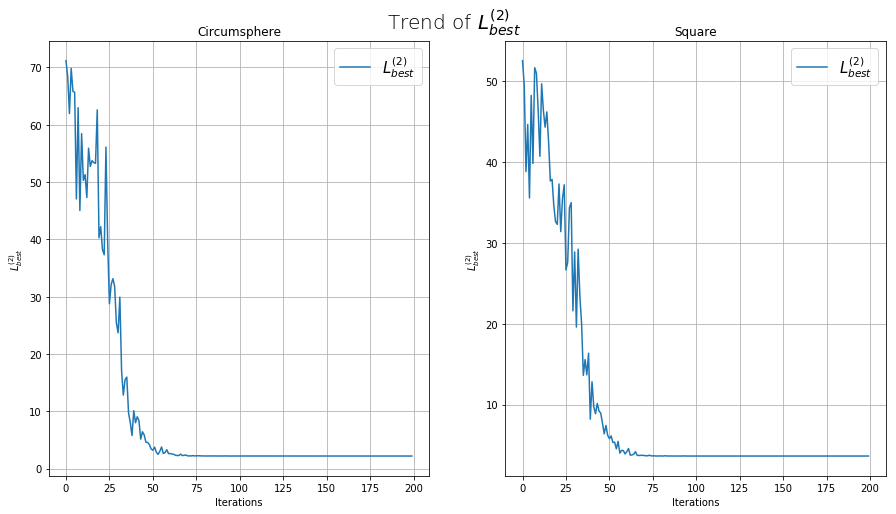

In [3]:
fig = plt.figure(figsize=(15, 8))
fig.suptitle('Trend of $L^{(2)}_{best}$', y='0.94', size='20', weight='20')
gs = gridspec.GridSpec(1, 2, figure=fig)

ax = fig.add_subplot(gs[0,0])
plt.plot(n, Lbest, label="$L^{(2)}_{best}$")
plt.xlabel('Iterations')
plt.ylabel('$L^{(2)}_{best}$')
ax.legend(fontsize=15)
plt.grid()
plt.title('Circumsphere')

ax2 = fig.add_subplot(gs[0,1])
plt.plot(nq, Lbestq, label="$L^{(2)}_{best}$")
plt.xlabel('Iterations')
plt.ylabel('$L^{(2)}_{best}$')
ax2.legend(fontsize=15)
plt.grid()
plt.title('Square')

plt.show()

Si nota come la convergenza è raggiunta già dopo 100 iterazioni per entrambe le configurazioni, cioè dopo aver studiato le prime 100 temperature, raggiungendo $T\simeq10^{-3}$. Questo lo si può notare anche dai rapporti di accettazione delle permutazioni stampate a terminale, che sono nulli o particolarmente piccoli già da metà dell'esecuzione.

A differenza del grafico analogo nell'esercizio dell'algoritmo genetico, noto come la funzione costo possa essere maggiore di quella calcolata al passo precedente perchè l'algoritmo utilizzato ha una probabilià non nulla di accettare un nuovo percorso più lungo del precedente: l'andamento, comunque è corretto e la funzione decresce velocemente abbassando la temperatura.

In [4]:
x, y = np.loadtxt('./Circ/Best_coordinates.res', usecols=(0,1), unpack=True)
xq, yq = np.loadtxt('./Quad/Best_coordinates.res', usecols=(0,1), unpack=True)

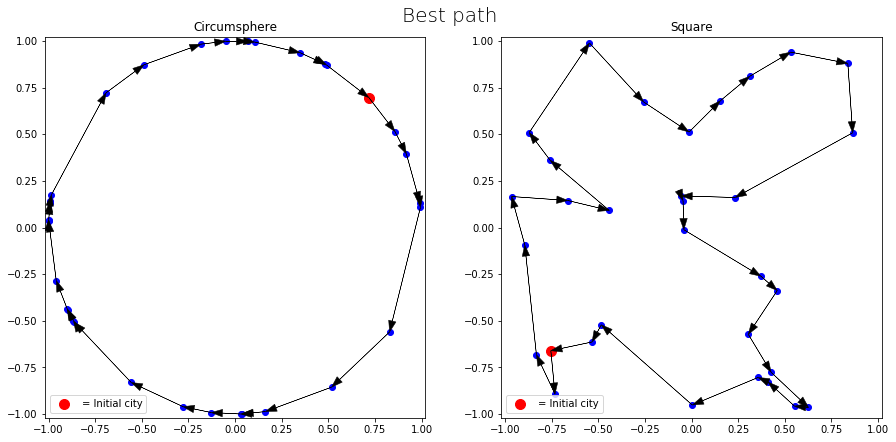

In [5]:
fig = plt.figure(figsize=(15, 7))
fig.suptitle('Best path', y='0.94', size='20', weight='20')
gs = gridspec.GridSpec(1, 2, figure=fig)

ax = fig.add_subplot(gs[0,0])
for i in range(len(x)):
    if i==0:
        plt.scatter(x[i],y[i], marker='.', s=400, color='red', label='= Initial city')
    else:
        plt.scatter(x[i],y[i], color='blue')
    if i<len(x)-1:
        plt.arrow(x[i], y[i], x[i+1]-x[i], y[i+1]-y[i], width=0, head_width=0.04,length_includes_head=True, lw=0.5, fc="black", ec='black')
    else:
        plt.arrow(x[i], y[i], x[0]-x[i], y[0]-y[i], width=0, head_width=0.04,length_includes_head=True, lw=0.5, fc="black", ec='black')
plt.xlim(-1.02,1.02)
plt.ylim(-1.02,1.02)
ax.legend(loc='lower left')
plt.title('Circumsphere')


ax2 = fig.add_subplot(gs[0,1])
for i in range(len(xq)):
    if i==0:
        plt.scatter(xq[i],yq[i], marker='.', s=400, color='red', label='= Initial city')
    else:
        plt.scatter(xq[i],yq[i], color='blue')
    if i<len(x)-1:
        plt.arrow(xq[i], yq[i], xq[i+1]-xq[i], yq[i+1]-yq[i], width=0, head_width=0.04,length_includes_head=True, lw=0.5, fc="black", ec='black')
    else:
        plt.arrow(xq[i], yq[i], xq[0]-xq[i], yq[0]-yq[i], width=0, head_width=0.04,length_includes_head=True, lw=0.5, fc="black", ec='black')
plt.xlim(-1.02,1.02)
plt.ylim(-1.02,1.02)
ax2.legend(loc='lower left')
plt.title('Square')
plt.show()

Per entrambe le configurazioni, i risultati sono gli stessi ottenuti nell'esercizio 9 con l'algoritmo genetico: questo avvalora l'ipotesi che i percorsi trovati siano dei minimi assoluti della funzione costo per la distribuzione di città estratta. Si nota come, nella disposizione delle città, il tragitto nel quadrato sia percorso in versi opposti nei due risultati: ciò può, ovviamente, avvenire a causa della degenerazione della funzione costo legata al verso di percorrenza.

## <span style="color:blue">  Esercizio 10.2</span>

Ho modificato il codice dell'esercitazione 9 per eseguire su quattro core in parallelo l'algoritmo genetico per risolvere il problema del commesso viaggiatore. Ho utilizzato la libreria MPI, sfruttando alcune delle sue funzioni (**MPI_Reduce, MPI_Bcast, MPI_Send, MPI_Recv**).

Nella funzione per il settaggio iniziale del generatore di numeri random ho fatto leggere ad ogni processo una riga differente del file <font face="Courier">Primes</font>, per formare generatori random con parametri differenti. 
Dopo aver generato le cordinate delle città le ho passate dal nodo 0 a tutti gli altri attraverso la funzione *MPI_Bcast*; ogni 100 iterazioni si è estratto il percorso minimo globale della simualazione passando al nodo 0 i minimi locali con la funzione *MPI_Reduce*; infine, ogni $n_{migr}$ iterazioni, due nodi estratti casualmente si scambiano il percorso migliore attraverso le funzioni *MPI_Send* e *MPI_Recv*.

Le potenzialità dell'esecuzione in parallelo sono legate al fatto che ogni nodo campiona in modo diverso i cammini, tramite mutazione e crossover e popolazione iniziale, aggiungendo statistica al problema. Inoltre lo scambio potrebbe aiutare i diversi nodi a non cadere in minimi locali.

La consegna è stata fatta con le stesse scelte di parametri dell'esercizio 9 su singolo core per confrontare i risultati.

In [6]:
x0, y0 = np.loadtxt('./LSN_10.2/Best_coordinates_rank0.res', usecols=(0,1), unpack=True)
x1, y1 = np.loadtxt('./LSN_10.2/Best_coordinates_rank1.res', usecols=(0,1), unpack=True)
x2, y2 = np.loadtxt('./LSN_10.2/Best_coordinates_rank2.res', usecols=(0,1), unpack=True)
x3, y3 = np.loadtxt('./LSN_10.2/Best_coordinates_rank3.res', usecols=(0,1), unpack=True)
x9, y9 = np.loadtxt('../lez09/Quad/Best_coordinates.res', usecols=(0,1), unpack=True)

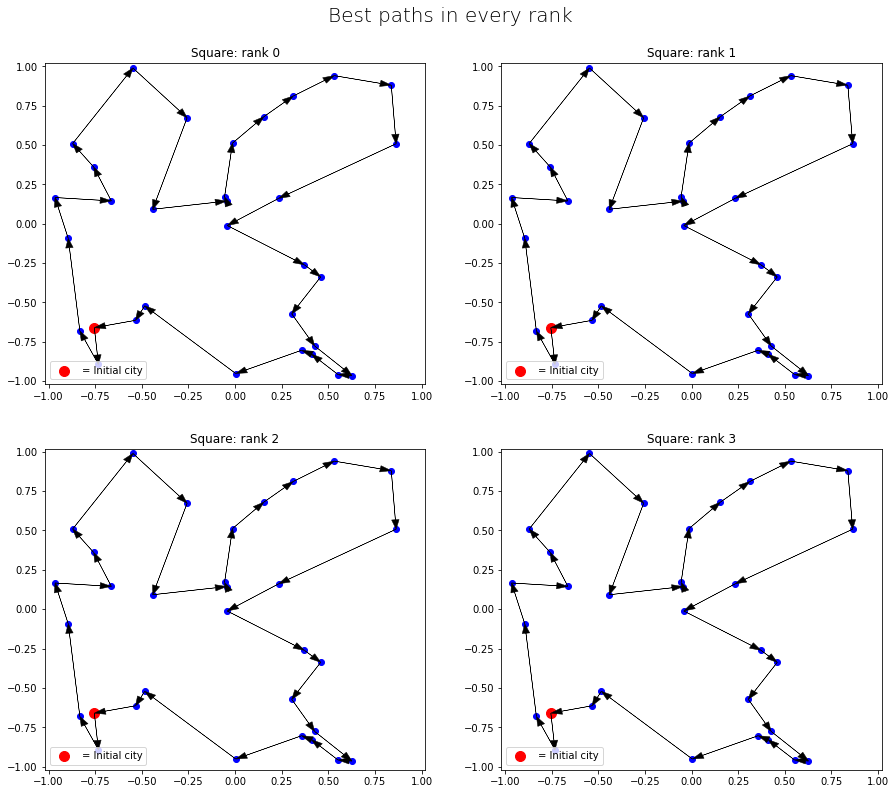

In [7]:
fig = plt.figure(figsize=(15, 13))
fig.suptitle('Best paths in every rank', y='0.94', size='20', weight='20')
gs = gridspec.GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[0,0])
for i in range(len(x0)):
    if i==0:
        plt.scatter(x0[i],y0[i], marker='.', s=400, color='red', label='= Initial city')
    else:
        plt.scatter(x0[i],y0[i], color='blue')
    if i<len(x0)-1:
        plt.arrow(x0[i], y0[i], x0[i+1]-x0[i], y0[i+1]-y0[i], width=0, head_width=0.04,length_includes_head=True, lw=0.5, fc="black", ec='black')
    else:
        plt.arrow(x0[i], y0[i], x0[0]-x0[i], y0[0]-y0[i], width=0, head_width=0.04,length_includes_head=True, lw=0.5, fc="black", ec='black')
plt.xlim(-1.02,1.02)
plt.ylim(-1.02,1.02)
ax1.legend(loc='lower left')
plt.title('Square: rank 0')

ax2 = fig.add_subplot(gs[0,1])
for i in range(len(x1)):
    if i==0:
        plt.scatter(x1[i],y1[i], marker='.', s=400, color='red', label='= Initial city')
    else:
        plt.scatter(x1[i],y1[i], color='blue')
    if i<len(x1)-1:
        plt.arrow(x1[i], y1[i], x1[i+1]-x1[i], y1[i+1]-y1[i], width=0, head_width=0.04,length_includes_head=True, lw=0.5, fc="black", ec='black')
    else:
        plt.arrow(x1[i], y1[i], x1[0]-x1[i], y1[0]-y1[i], width=0, head_width=0.04,length_includes_head=True, lw=0.5, fc="black", ec='black')
plt.xlim(-1.02,1.02)
plt.ylim(-1.02,1.02)
ax2.legend(loc='lower left')
plt.title('Square: rank 1')

ax3 = fig.add_subplot(gs[1,0])
for i in range(len(x2)):
    if i==0:
        plt.scatter(x2[i],y2[i], marker='.', s=400, color='red', label='= Initial city')
    else:
        plt.scatter(x2[i],y2[i], color='blue')
    if i<len(x2)-1:
        plt.arrow(x2[i], y2[i], x2[i+1]-x2[i], y2[i+1]-y2[i], width=0, head_width=0.04,length_includes_head=True, lw=0.5, fc="black", ec='black')
    else:
        plt.arrow(x2[i], y2[i], x2[0]-x2[i], y2[0]-y2[i], width=0, head_width=0.04,length_includes_head=True, lw=0.5, fc="black", ec='black')
plt.xlim(-1.02,1.02)
plt.ylim(-1.02,1.02)
ax3.legend(loc='lower left')
plt.title('Square: rank 2')

ax4 = fig.add_subplot(gs[1,1])
for i in range(len(x3)):
    if i==0:
        plt.scatter(x3[i],y3[i], marker='.', s=400, color='red', label='= Initial city')
    else:
        plt.scatter(x3[i],y3[i], color='blue')
    if i<len(x3)-1:
        plt.arrow(x3[i], y3[i], x3[i+1]-x3[i], y3[i+1]-y3[i], width=0, head_width=0.04,length_includes_head=True, lw=0.5, fc="black", ec='black')
    else:
        plt.arrow(x3[i], y3[i], x3[0]-x3[i], y3[0]-y3[i], width=0, head_width=0.04,length_includes_head=True, lw=0.5, fc="black", ec='black')
plt.xlim(-1.02,1.02)
plt.ylim(-1.02,1.02)
ax4.legend(loc='lower left')
plt.title('Square: rank 3')

plt.show()

I percorsi migliori calcolati nei quattro processi sono identici, ma leggermente diversi da quelli campionati nell'esercitazione precedente.

In [8]:
n, Lbest= np.loadtxt('./LSN_10.2/Evolution.res', usecols=(0,1), unpack='true')
nq, Lq, Lbestq= np.loadtxt('../lez09/Quad/Evolution.res', usecols=(0,1,2), unpack='true')

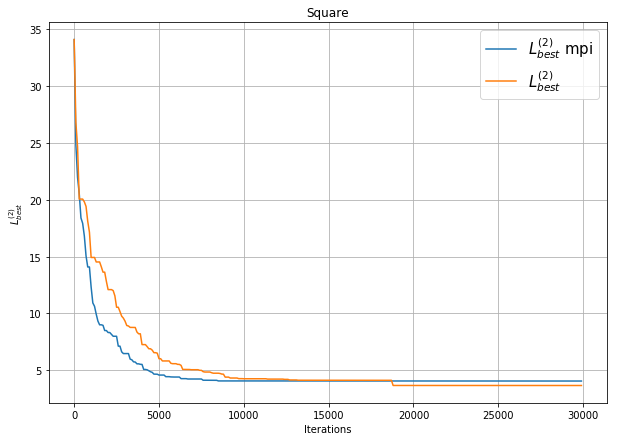

In [12]:
plt.figure(figsize=(10,7))
plt.plot(n, Lbest, label="$L^{(2)}_{best}$ mpi")
plt.plot(nq, Lbestq, label="$L^{(2)}_{best}$")
plt.xlabel('Iterations')
plt.ylabel('$L^{(2)}_{best}$')
plt.legend(fontsize=15)
plt.grid()
plt.title('Square')
plt.show()

In [11]:
print("Lunghezza percorso migliore con singolo processore: "+str(Lbestq[-1]))
print("Lunghezza percorso migliore con 4 processori: "+str(Lbest[-1]))

Lunghezza percorso migliore con singolo processore: 3.64896
Lunghezza percorso migliore con 4 processori: 4.04243


Noto, con un pizzico di sorpresa, che il codice che processa con i quattro nodi in parallelo dà come risultato finale un percorso con funzione costo leggermente maggiore a quella trovata con un singolo continente.
Osservo, invece, come la decrescita del valore della funzione costo sia molto più rapida per il processo in parallelo; il sistema, però, si blocca nel minimo locale da cui, invece, esce nel caso di singolo processo dopo circa 19000 iterazioni: si pensa che questa stagnazione sia dovuta alla lettura di diversi semi nel file *Primes* (quello letto nell'esercizio 9 potrebbe essere particolarmente favorevole per raggiungere il minimo) e dalla scelte delle probabilità di crossover e mutazione.